# AutoEncoder: Applications and Generalization

BY: Dr. Jie Tao

VER.: 0.1

Now we understand the basics of AutoEncoders, we can discuss how can we use it in the field.

As a re-cap, we like AutoEncoders (AEs) because of the following characteristics:
1. Non-linear Transformations – it can learn non-linear activation functions and multiple layers.
3. Higher Efficiency – More efficient in model parameters to learn several layers with an autoencoder rather than learn one huge transformation with PCA.
4. Multiple transformations – An autoencoder also gives a representation as to the output of each layer, and having multiple representations of different dimensions is always useful. An autoencoder lets you use pre-trained layers from another model to apply transfer learning to prime the encoder and decoder.
5.  Unsupervised – They do not need labels to train on.

6.  data specific – They can only compress the data similar to what they have been trained on. for example, an autoencoder trained on the human face will not perform well on images of modern buildings. This improvises the difference between auto-encoder and mp3 kind of compression algorithm, which only holds assumptions about sound.

7. Lossy – Autoencoders are lossy, meaning the decompressed output will be degraded.




__PRO-TIP__: even though AEs are designed to use as a compression tool, we hardly any use it for that.

Typically, we use AEs for the following two purposes:
- Dimension Reduction
- Anomaly Detection.

Let's talk about them.

## AEs for Dimension Reduction

This application is very straightforward and tightly linked to the original compression purpose of AEs.

You can think of it as "compression" on the feature dimension (columns). So we are creating **latent features** instead of using original input features.

---

__DO YOU REMEMBER__:

Latent features are the features in the latent space, and the latent space is the space between the encoder and decoder parts in an AE.

---

You can think this as something like Principle Component Analysis (PCA). Instead of using PCs as features, we are using the features from the latent space.

Let's showcase this using the Fashion MNIST dataset.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.utils import plot_model
import pandas as pd
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

### Load and Process Data

Now let's load the data.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Normalize the data.

In [ ]:
# Normalize pixel values to [0., 1.]
x_train = x_train / 255.
x_test = x_test / 255.

Now we can visualize the first 10 images.

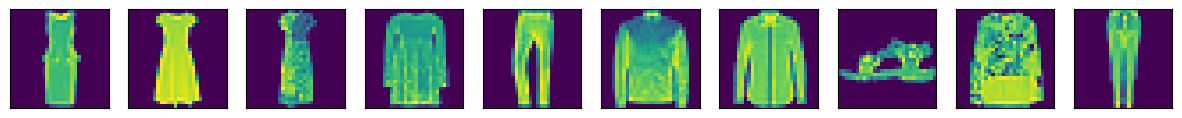

In [ ]:
# Take a look at the dataset
n_samples = 10
idx = random.sample(range(x_train.shape[0]), n_samples)
plt.figure(figsize=(15,4))
for i in range(n_samples):
    plt.subplot(1, n_samples, i+1)
    plt.imshow(x_train[idx[i]].squeeze());
    plt.xticks([], [])
    plt.yticks([], [])

We know each image has $28 \times 28 = 784 $ features. A simple use case would be If we want to visualize the features it is impossible (we cannot handle more than 3 features/dimensions). So we need to reduce the dimensionality to `2`.

### Building the autoencoder
Please keep in mind that whatever has to do with image classification works better with convolutional neural networks of some sort. However, here we keep it simple and go with dense layers. Feel free to change the number of layers, the number of units, and the activation functions. My choice is by no way optimal nor the result of an exhaustive exploration.



In [ ]:
# This is the dimension of the latent space (encoding space)
latent_dim = 2

# Images are 28 by 28
img_shape = (x_train.shape[1], x_train.shape[2])

encoder = Sequential([
    Flatten(input_shape=img_shape),
    Dense(192, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(32, activation='sigmoid'),
    Dense(latent_dim, name='encoder_output')
])

decoder = Sequential([
    Dense(64, activation='sigmoid', input_shape=(latent_dim,)),
    Dense(128, activation='sigmoid'),
    Dense(img_shape[0] * img_shape[1], activation='relu'),
    Reshape(img_shape)
])

### Creating a custom callback
Here comes the cool part. To visualize how the autoencoder builds up the latent space representation, as we train it, we will create a custom callback by subclassing the `tf.keras.callbacks.Callback`. We will then override the method `on_epoch_begin(self, epoch, logs=None)`, which is called at the beginning of an epoch during training. There, we will hook up our code to extract the latent space representation and plot it. To obtain the output of an intermediate layer (in our case, we want to extract the encoder’s output), we will retrieve it via the `layer.output`. Here’s how:

In [ ]:
class TestEncoder(tf.keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        super(TestEncoder, self).__init__()
        self.x_test = x_test
        self.y_test = y_test
        self.current_epoch = 0
    #### We use the method below to extract the encoder output, and to plot them out
    def on_epoch_begin(self, epoch, logs={}):
        self.current_epoch = self.current_epoch + 1
        #### initialize the encoder model
        encoder_model = Model(inputs=self.model.input,
                              outputs=self.model.get_layer('encoder_output').output)
        #### retrieve the encoder output
        encoder_output = encoder_model(self.x_test)
        #### plotting
        plt.subplot(4, 3, self.current_epoch)
        plt.scatter(encoder_output[:, 0],
                    encoder_output[:, 1], s=20, alpha=0.8,
                    cmap='Set1', c=self.y_test[0:x_test.shape[0]])
        plt.xlim(-9, 9)
        plt.ylim(-9, 9)
        plt.xlabel('Latent Dimension 1')
        plt.ylabel('Latent Dimension 2')

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

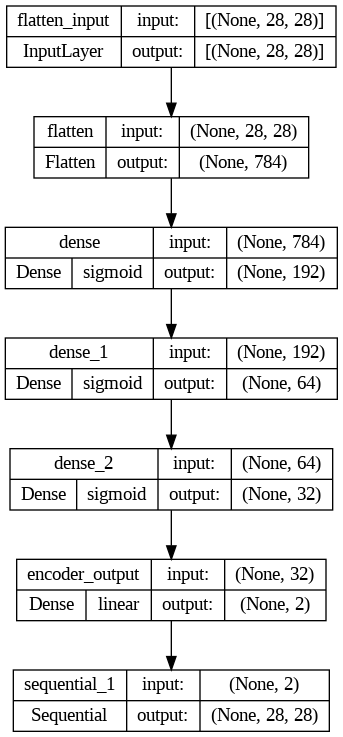

In [ ]:
plot_model(autoencoder, show_shapes=True, show_layer_activations=True)

### Training

Now let's train the autoencoder.

Because of our callback, now we can visualize the changes between epochs in the latent space, to make sure our AE actually learned.

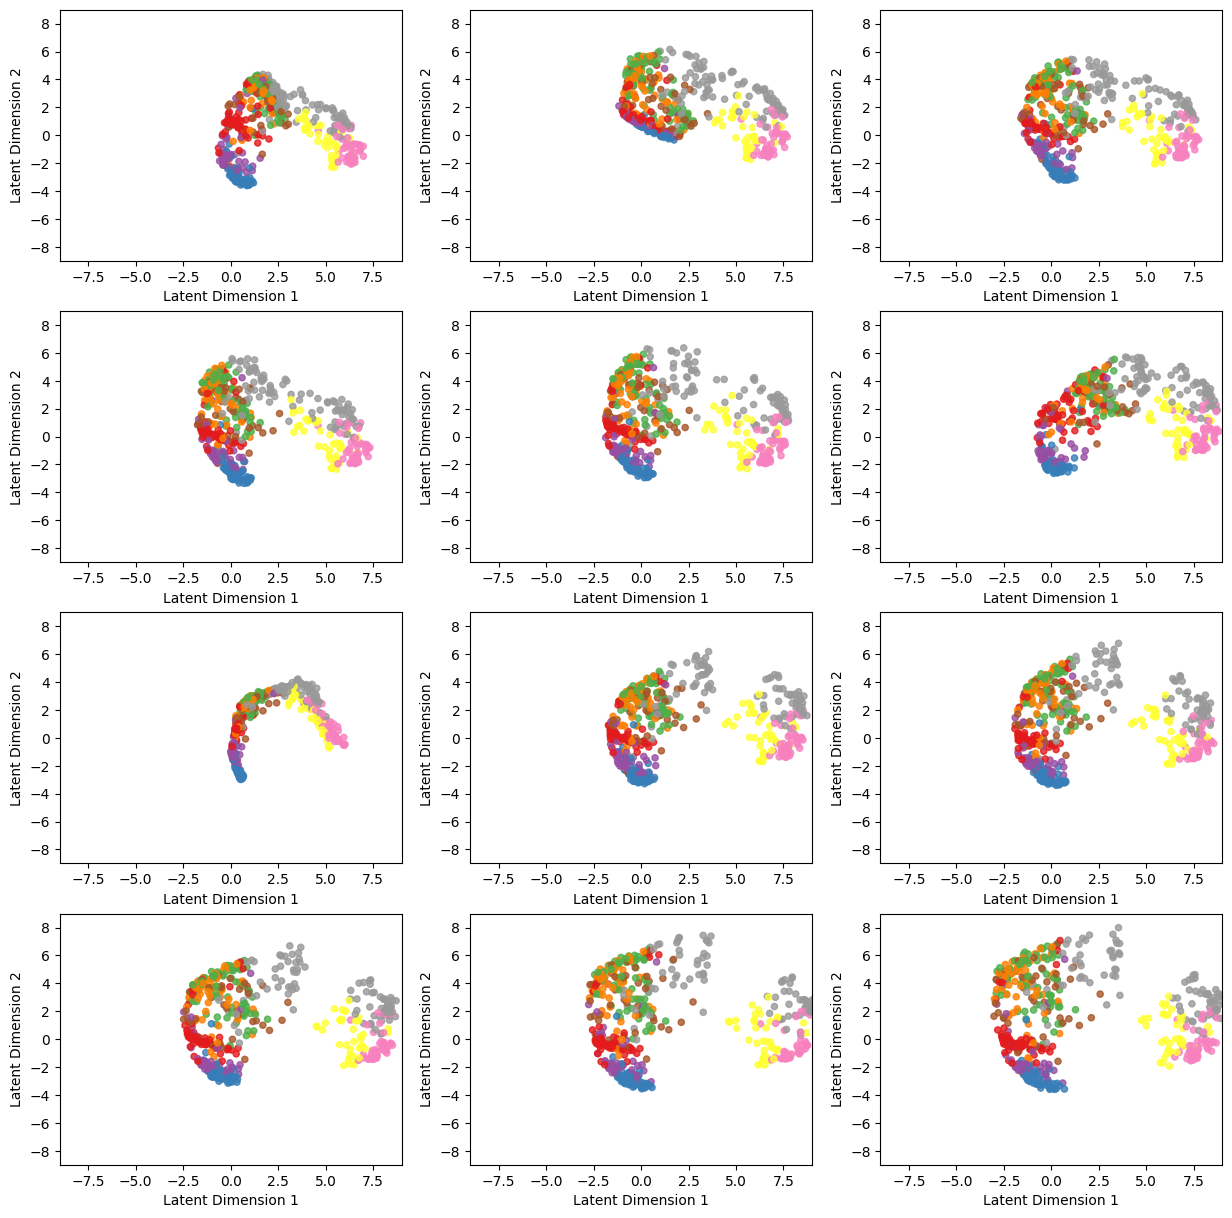

In [ ]:
plt.figure(figsize=(15,15))
model_history = autoencoder.fit(x_train, x_train, epochs=12, batch_size=32, verbose=0,
                                callbacks=[TestEncoder(x_test[0:500], y_test[0:500])]) ### We limit the visuals to 500 data points

#### DO IT YOURSELF

Change the activation function in the last `Dense` layer in the __decoder__ from `relu` to `tanh`, observe how the visuals change.

### Comparison to PCA

We can compare the results using PCA.

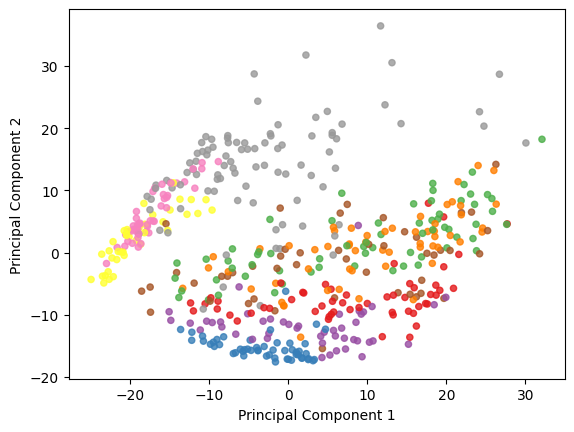

In [ ]:
pca = PCA(n_components=2)
x_reshaped = x_test[0:500].reshape(-1, 784)              # new shape is (500, 28*28) = (500, 784)
x_scaled = StandardScaler().fit_transform(x_reshaped)    # center and scale data (mean=0, std=1)
x_transformed = pca.fit(x_scaled).transform(x_scaled)

plt.figure()
plt.scatter(x_transformed[:, 0], x_transformed[:, 1],
            s=20, alpha=.8, cmap='Set1', c=y_test[0:500])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2');

You can certainly see the AE results (at epoch `12`) is cleaner than PCA. This is because AEs can capture both linear (PCA can do this) and **non-linear** relationships.

There is another popular dimension reduction technique called T-SNE (T-distributed Stochastic Neighbor Embedding), let's try it on our data as well.



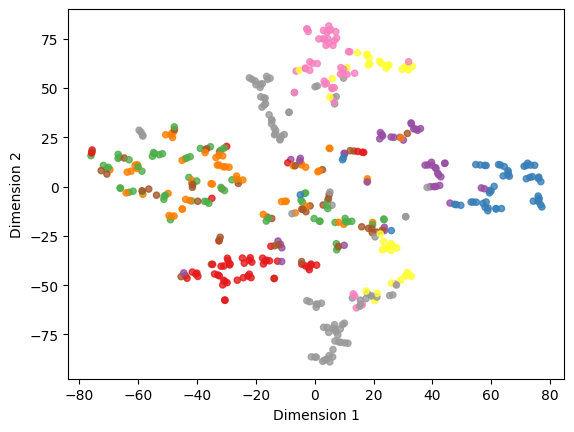

In [ ]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                   init='random', perplexity=3).fit_transform(x_scaled)
plt.figure()
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            s=20, alpha=.8, cmap='Set1', c=y_test[0:500])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2');

You can see compare to PCA, T-SNE is much better in some classes but not good in the other.

__PRO-TIP__: You should definitely consider AEs as a feature engineering tool. T-SNE is usually used for visualizations.

#### PCA vs. AE
- By definition, PCA is a linear transformation, whereas AEs are capable of modeling complex non-linear functions. There is, however, kernel PCA that can model non-linear data.
- In PCA, features are by definition linearly uncorrelated. Recall that they are projections onto an orthogonal basis. On the contrary, autoencoded features might be correlated. The two optimization objectives are simply different (an orthogonal basis that maximizes variance when data are projected onto it vs. maximum accuracy reconstruction).
- PCA is computationally less demanding than autoencoders. For instance, PCA on the MNIST dataset takes 0.05 seconds +/- 0.008 in my PC, whereas training the AE around 3-4 minutes.
- Autoencoders having many trainable parameters are vulnerable to overfitting, similar to other neural networks.


### BONUS CONTENT: How can we use the latent features?

We can use the features for classification, of course. But is there any other interesting use of these latent features?

For sure yes! We can use them to __generate__ data:

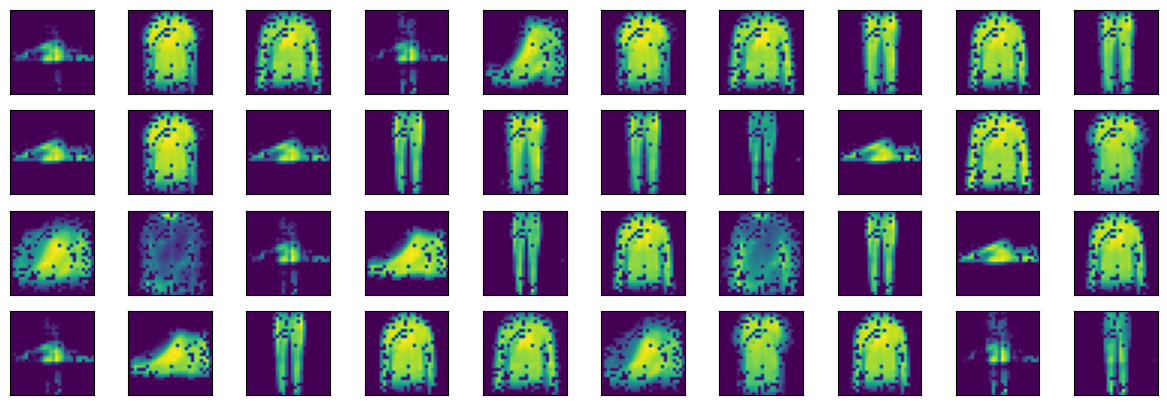

In [ ]:
n_samples = 40
fake_sample = np.random.uniform(low=-20, high=20, size=(n_samples, 2))
plt.figure(figsize=(15,5))
for i in range(n_samples):
    plt.subplot(4, n_samples//4, i+1)
    fake_encoding = np.array([fake_sample[i]])
    ### we are using random values as the latent feature values
    ### and feed them into the trained decoder
    ### you must realized we never used the decoder above right???
    fake_digit = decoder(fake_encoding).numpy().squeeze()
    plt.imshow(fake_digit);
    plt.xticks([], [])
    plt.yticks([], [])


You can observe that these features are noisy (dark pixels), but most of them are reasonable, no?

__PRO-TIPs__:
1. This is where most generative model started - using a trained decoder.
2. In practice, we use variational autoecoders (VAEs) much more for generative purposes. You can see from above examples that the generated images are very similar to the originals. Sometimes we want some variations, hence VAE. Refer to [this article](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) if you want to learn more about VAEs.

## Anomaly Detection

Another important use case of AEs is __anomaly detection__. Here we are using the _lossy_ characteristic of AEs. Lossy means information get lost somewhere in AEs - which is common in any compression methods.

By using AEs for anomaly detection, we have an important assumption:


> Majority of your data does __NOT__ contains any noise.

The reason above assumption is important is noises, a.k.a. anomalies, should not happen too often in your data. Which means your model (particularly the __encoder__) does not learn too much from them. Thus, when we use the __decoder__ to reconstruct the data, the noises/anomalies should be excluded.



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

In [ ]:
## Download and extract data
!wget http://www.timeseriesclassification.com/Downloads/ECG5000.zip
!unzip ./ECG5000.zip
!cat "./ECG5000_TRAIN.txt" "./ECG5000_TEST.txt" > ecg_final.txt

--2023-05-29 23:28:54--  http://www.timeseriesclassification.com/Downloads/ECG5000.zip
Resolving www.timeseriesclassification.com (www.timeseriesclassification.com)... 109.123.71.232
Connecting to www.timeseriesclassification.com (www.timeseriesclassification.com)|109.123.71.232|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10614407 (10M) [application/zip]
Saving to: ‘ECG5000.zip.2’

ECG5000.zip.2       100%[===================>]  10.12M  11.4MB/s    in 0.9s    

2023-05-29 23:28:55 (11.4 MB/s) - ‘ECG5000.zip.2’ saved [10614407/10614407]

Archive:  ./ECG5000.zip
replace ECG5000.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ECG5000.txt             
replace ECG5000_TEST.arff? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ECG5000_TEST.arff       
  inflating: ECG5000_TEST.txt        
  inflating: ECG5000_TRAIN.arff      
  inflating: ECG5000_TRAIN.txt       
  inflating: ECG5000_TEST.ts         
  inflating: ECG5000_TRAIN.ts        


In [ ]:
## read-in the data using pandas
df = pd.read_csv("./ecg_final.txt", sep='  ', header=None, engine="python")
df.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,1.0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,...,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137
1,1.0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,...,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250
2,1.0,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,...,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797
3,1.0,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,...,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564
4,1.0,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,...,0.966606,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456


### Basic Preprocessing
Pandas give the default name as numeric to the column name, so we cannot do any processing because pandas do not allow slice and dice if we have only numeric in the column name. So, we are adding any prefix to the column name to do slice and dice on columns.

In [ ]:
df = df.add_prefix('c')
df['c0'].value_counts()

1.0    2919
2.0    1767
4.0     194
3.0      96
5.0      24
Name: c0, dtype: int64

Suppose we see the number of records in each category using the value counts function. In that case, we see one has more number of observations so that we will take the first category into the normal data and combine the data from the second category to the fifth as abnormal.

#### Train-Test Splitting and Scaling the data

Before separating the data as normal and abnormal, we split the data into train and test sets. Neural networks give a good performance when data is scaled on a common scale, so we normalize the data.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.values, df.values[:,0:1], test_size=0.2, random_state=42)
scaler = MinMaxScaler()
data_scaled = scaler.fit(x_train)
train_data_scaled = data_scaled.transform(x_train)
test_data_scaled = data_scaled.transform(x_test)

#### Separate Anomaly and Normal Data

Now we will split the training data into normal data and anomaly data. We know how to split these two datasets based on the value train data scale means the first category in normal data and the remaining category data in anomaly data. And the same applies to test data.

In [ ]:
normal_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_train_data = pd.DataFrame(train_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]
normal_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 == 0').values[:,1:]
anomaly_test_data = pd.DataFrame(test_data_scaled).add_prefix('c').query('c0 > 0').values[:, 1:]

Now the training dataset has its own normal and anomaly dataframe. This is an `80-20` split. The dataset is not highly imbalanced that we need to do anything, but anyway, like for Autoencoder, we will train only with a normal dataset. An anomaly dataset will only be used for validation and finding inference.

### Data Visualization
Data visualization is vital to understanding the relationship between two or more variables. So that we can see how the data differs, let us first plot the normal data.

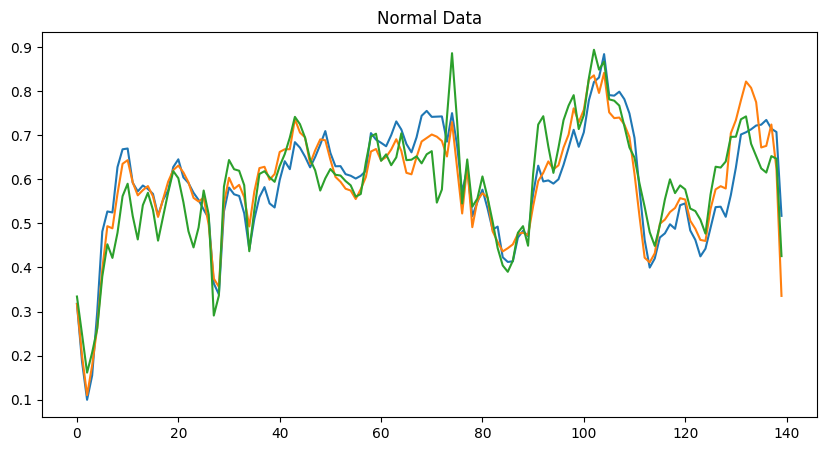

In [ ]:
plt.plot(normal_train_data[0])
plt.plot(normal_train_data[1])
plt.plot(normal_train_data[2])
plt.title("Normal Data");

We plot the first three columns. At an initial level, it is dropped because ECG measurement starts from there, and then it moves in a normal way. Now let us plot take anomaly data on the contrary.

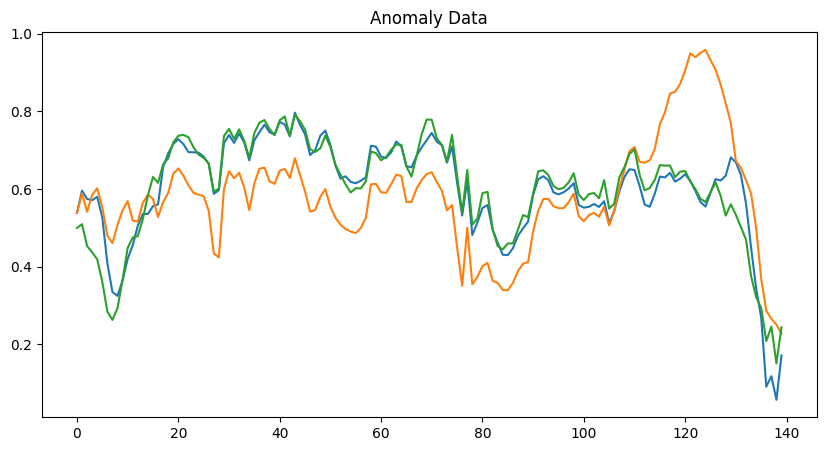

In [ ]:
plt.plot(anomaly_train_data[0])
plt.plot(anomaly_train_data[1])
plt.plot(anomaly_train_data[2])
plt.title("Anomaly Data");

By observing the above graphs difference between normal and anomaly data can be easily understood. If you remember about the term reconstruction error we discussed above, we will use it to identify and differentiate anomaly and normal data.

### Modelling
To create an autoencoder model, there are two ways. One is to use Sequential modelling provided by Keras API on top of TensorFlow. First, we add the encoding layer, decoding layers and one intermediate layer. It converts the data from a higher dimension into a lower dimension. And then, to reconstruct the data back, it uses an upsampler. The below code snippet defines this architecture.
```python
model = Sequential()
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(8, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(140, activation="sigmoid"))
```
In this case we define the model as a __class__. We do it this way because it allows us to use encoder and decoder separately easily.

#### Define the Model

In [ ]:
class AutoEncoder(Model):
  def __init__(self):
    super(AutoEncoder, self).__init__()
    self.encoder = Sequential([
                  Dense(64, activation="relu"),
                  Dense(32, activation="relu"),
                  Dense(16, activation="relu"),
                  Dense(8, activation="relu")
              ])
    self.decoder = Sequential([
                  Dense(16, activation="relu"),
                  Dense(32, activation="relu"),
                  Dense(64, activation="relu"),
                  Dense(140, activation="sigmoid")
              ])
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

Explanation ~ Above, we create a class and create a constructor, and then we create an encoder in the same way of decreasing layer order and 8 units are bottleneck layers. Then we have a decoder that does upsampling of the data that is downsampled by an encoder and finally, the output is 140 units. depending on the problem statement number of units changes. The final activation function is sigmoid. The call function calls the encoder and passes the input data and the encoded data is passed to the decoder. So this Autoencoder is a class and when I run this class it will return the final model object which contains an encoder, bottleneck layer, and a decoder.

#### Compile and train the Model

We are adding the *Early Stopping* phenomenon which terminates the training if the validation loss is not decreasing after two epochs. Then we compile the Model using Adam optimizer. we use **MAE**(mean absolute error) as a loss function. Now we pass the train data to the Model (we pass it two times because it is a mandatory field so pass a dummy Y values). We add `50` epochs but due to early stopping, it will not run too many epochs. If you are using time-series data then the order is important so you have to set shuffle to `False`.

In [ ]:
model = AutoEncoder()
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")
model.compile(optimizer='adam', loss="mae")
history = model.fit(normal_train_data, normal_train_data, epochs=50, batch_size=120,
                    validation_data=(train_data_scaled[:,1:], train_data_scaled[:, 1:]),
                    shuffle=True,
                    callbacks=[early_stopping]
                    )

Epoch 1/50
20/20 [==============================] - 2s 16ms/step - loss: 0.1172 - val_loss: 0.1041
Epoch 2/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0744 - val_loss: 0.0799
Epoch 3/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0517 - val_loss: 0.0763
Epoch 4/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0471 - val_loss: 0.0755
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0465 - val_loss: 0.0751
Epoch 6/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0464 - val_loss: 0.0746
Epoch 7/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0463 - val_loss: 0.0743
Epoch 8/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0461 - val_loss: 0.0739
Epoch 9/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0460 - val_loss: 0.0736
Epoch 10/50
20/20 [==============================] - 0s 9ms/step - loss: 0.0459 - val_loss: 0.0732
Epoch 11/50
20/20

### Model Evaluation
In Autoencoders difference between training loss and validation loss is high. It does not mean that Model is underfitting. The reason is in the validation function I am giving both the normal data and abnormal data against training data as normal data so you will see this kind of behaviour which is completely fine that’s why we are having early stopping. I can get my encoder and decoder output separately.



In [ ]:
encoder_out = model.encoder(normal_test_data).numpy() #8 unit representation of data
decoder_out = model.decoder(encoder_out).numpy()

First, we will plot the performance on Normal data which is first-class data.

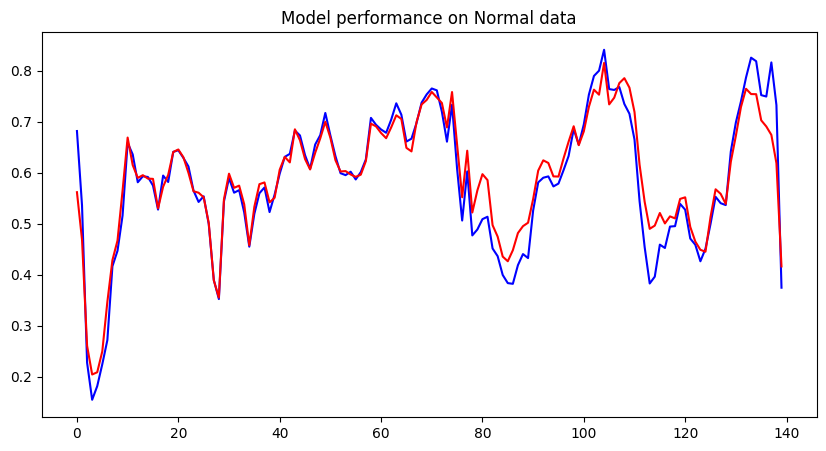

In [ ]:
plt.plot(normal_test_data[0], 'b')
plt.plot(decoder_out[0], 'r')
plt.title("Model performance on Normal data");

As discussed there will be a very little reconstruction error on Normal data which we can see in the above graph. The difference between both the red and blue lines is very less. what if I pass the anomaly test data.

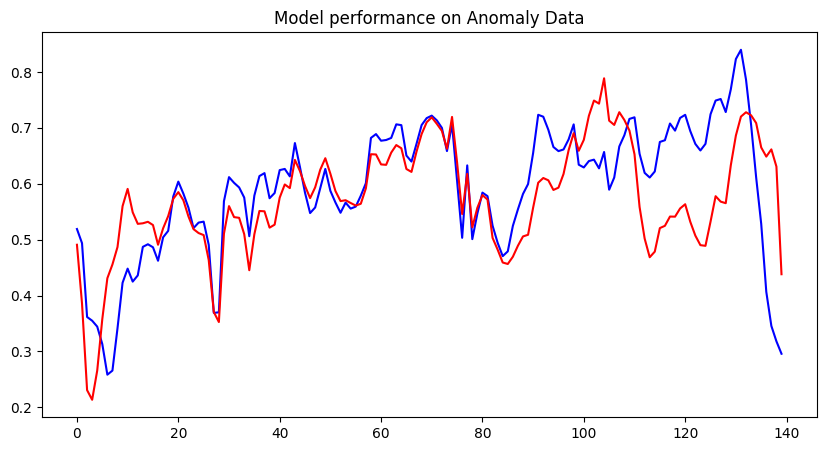

In [ ]:
encoder_out_a = model.encoder(anomaly_test_data).numpy() #8 unit representation of data
decoder_out_a = model.decoder(encoder_out_a).numpy()
plt.plot(anomaly_test_data[0], 'b')
plt.plot(decoder_out_a[0], 'r')
plt.title("Model performance on Anomaly Data");

You can observe that the reconstruction error on the anomaly data is __much higher__ than it on the normal data. You guessed right - we are going to use it as the metric to distinguish normal from abnormal data.

#### Calculate Reconstruction Loss

Now we will define our loss like threshold loss for our Model which gives us an output error between input and output. we define the Keras loss function over mean absolute error and plot it in form of a histogram.

19/19 [==============================] - 0s 2ms/step


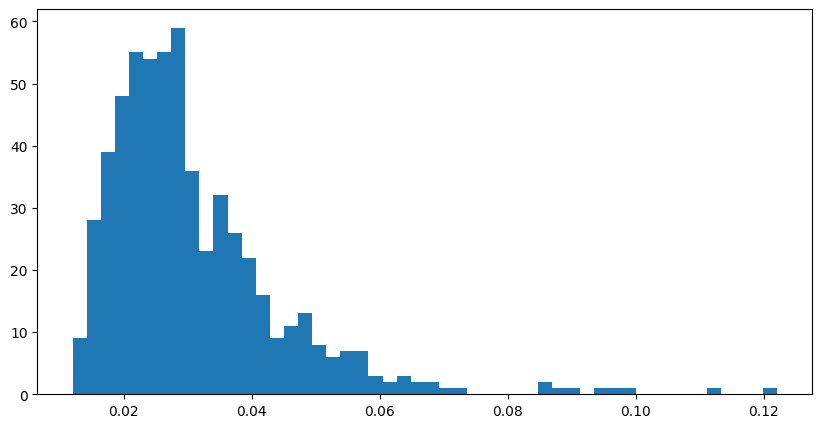

In [ ]:
reconstruction = model.predict(normal_test_data)
train_loss = tf.keras.losses.mae(reconstruction, normal_test_data)
plt.hist(train_loss, bins=50);

If you see the X-axis then most of the values lie below __the median__ (~.`07`). there are a few anomalies because we cannot have a 100% perfect model. This is how the error looks like between normal data and reconstructed data. Now we want to set a threshold from which we can tell that value above it is anomalies and below it is normal data so we take the mean of training loss and multiply it with second standard deviation. The threshold should be set as per business standards.

13/13 [==============================] - 0s 2ms/step


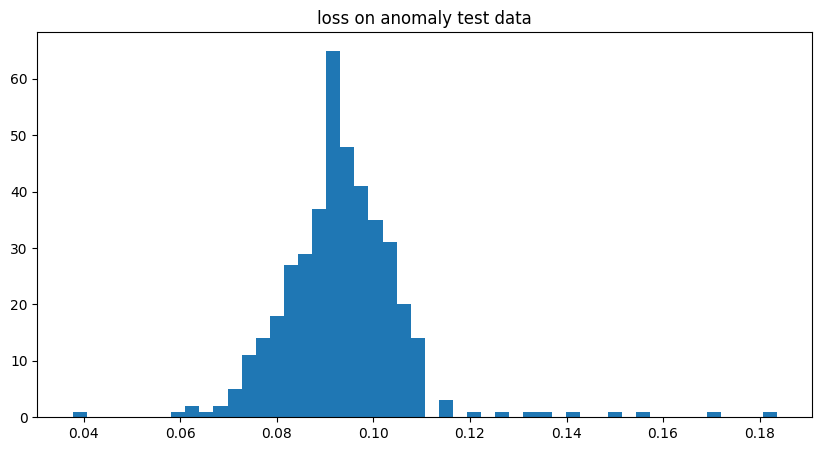

In [ ]:
threshold = np.mean(train_loss) + 2*np.std(train_loss)
reconstruction_a = model.predict(anomaly_test_data)
train_loss_a = tf.keras.losses.mae(reconstruction_a, anomaly_test_data)
plt.hist(train_loss_a, bins=50)
plt.title("loss on anomaly test data");

If you saw the above graph then most of the data were below __the median__ (~`.11`), and if we plot histogram on anomaly test data loss then most of the data lies above the median on the normal data. Observe the separation between normal data loss and anomaly data loss; hence, we got a very good model.

#### Plot Normal and anomaly Loss together

To get a better idea of how both losses together look like let us plot both the loss along with the threshold. So we pass the normal training loss and anomaly loss in a separate histogram on a single graph. we are drawing a vertical line on the graph which is the threshold for better visualization.

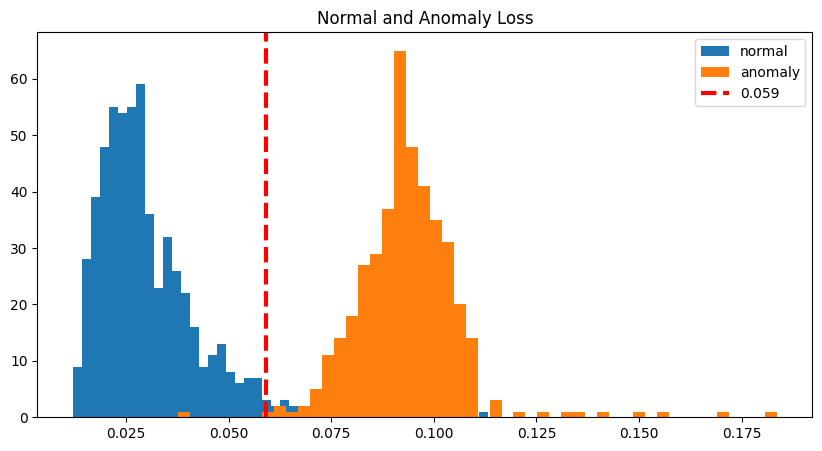

In [ ]:
plt.hist(train_loss, bins=50, label='normal')
plt.hist(train_loss_a, bins=50, label='anomaly')
plt.axvline(threshold, color='r', linewidth=3, linestyle='dashed', label='{:0.3f}'.format(threshold)) ### this is the threshold
plt.legend(loc='upper right')
plt.title("Normal and Anomaly Loss");

Now if you see a mean anomaly loss then earlier it was `33` percent but not it is 90 percent which is way far but the standard deviation will be close. Now we have a very good understanding of model performance so let us see how many false positives and false negatives are there so that we can define the average model performance.

#### How well does it predict Normal/Abnormal Class?

In [ ]:
preds = tf.math.less(train_loss, threshold) ### reconstruction loss less than threshold are predicted normal
print("out of {} instances, {} are correctly predicted to be normal".format(len(preds), tf.math.count_nonzero(preds)))
print("Normal Class Accuracy:", int(tf.math.count_nonzero(preds))/len(preds))

out of 586 instances, 563 are correctly predicted to be normal
Normal Class Accuracy: 0.9607508532423208


#### DO IT YOURSELF

Can you print out the results using our method predict the __Abnormal__ class?

__PRO-TIPs__:

1. We love this method because it is purely __unsupervised__, labelling anomalies is a huge error-prone endeavor.
2. The `threshold` can be algorithmically determined.
3. You can always use stronger AEs, like the convolutional or recurrecnt AEs for this.

## Generalization: Encoder-decoder model, or Seq2seq model

Continue to the next part of the tutorial

## References

1. [Complete Guide to Anomaly Detection with AutoEncoders using Tensorflow](https://www.analyticsvidhya.com/blog/2022/01/complete-guide-to-anomaly-detection-with-autoencoders-using-tensorflow/)
2. [The encoder-decoder model as a dimensionality reduction technique](https://ekamperi.github.io/machine%20learning/2021/01/21/encoder-decoder-model.html)
3. [Keras implementation of an encoder-decoder for time series prediction using architecture](https://awaywithideas.com/keras-implementation-of-a-sequence-to-sequence-model-for-time-series-prediction-using-an-encoder-decoder-architecture/)